In [ ]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# for time measurement
import time

# some utilities for counting
from collections import defaultdict, Counter

# plotting
import matplotlib.pyplot as plt

# plotting cosmetics
%config InlineBackend.figure_format = 'svg' 
plt.style.use('seaborn')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def read_data(corpus_file, use_sentiment=True):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            product, sentiment, _, doc = line.strip().split(maxsplit=3)
            X.append(doc)
            Y.append(sentiment if use_sentiment else product)
    return X, Y

In [ ]:
!mkdir data
!wget http://www.cse.chalmers.se/~richajo/nlp2019/l1/l1_data.zip
!unzip l1_data.zip
!mv all_sentiment_shuffled.txt data

--2021-08-10 03:35:34--  http://www.cse.chalmers.se/~richajo/nlp2019/l1/l1_data.zip
Resolving www.cse.chalmers.se (www.cse.chalmers.se)... 129.16.221.33
Connecting to www.cse.chalmers.se (www.cse.chalmers.se)|129.16.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3483101 (3.3M) [application/zip]
Saving to: ‘l1_data.zip’

l1_data.zip         100%[===================>]   3.32M   797KB/s    in 13s     

2021-08-10 03:35:47 (272 KB/s) - ‘l1_data.zip’ saved [3483101/3483101]

Archive:  l1_data.zip
  inflating: all_sentiment_shuffled.txt  


In [ ]:
X, Y = read_data('data/all_sentiment_shuffled.txt', use_sentiment=True)

In [ ]:
X[3]

'anything you purchase in the left behind series is an excellent read . these books are great and very close to the bible . i have the entire set . amazon is a great shopping site and they ship fast . i would recommend these to any christian wanting to know about what to expect during the return of christ ! they are fiction but still makes a good point'

In [ ]:
Y[3]

'pos'

In [ ]:
PAD = '___PAD___'
UNKNOWN = '___UNKNOWN___'


class Vocabulary:
  """Manages the numerical encoding of the vocabulary"""
  def __init__(self, tokenizer=None, max_voc_size=None):

    # String-to-integer mapping
    self.stoi = None

    # Integer-to-string mapping
    self.itos = None


    # Tokenizer that will be used to split document strings into words.
    if tokenizer:
      self.tokenizer = tokenizer
    else:
      self.tokenizer = lambda s: s.split()

    
    # Maximally allowed vocabulary
    self.max_voc_size = max_voc_size

  def build(self, docs):
    """Builds the vocabulary based on a set of documents."""

    # Sort all words by frequency
    word_freqs = Counter(w for doc in docs for w in self.tokenizer(doc))
    word_freqs = sorted(((f, w) for w, f in word_freqs.items()), reverse=True)


    # Build the integer-to-strings mapping. The vocabulary starts with two dummy symbols,
    # and then all words, sorted by frequency. Optionally,limit the vocabulary size.
    if self.max_voc_size:
      self.itos = [PAD, UNKNOWN] + [ w for _, w in word_freqs[:self.max_voc_size-2] ]
    else:
      self.itos = [PAD, UNKNOWN] + [ w for _, w in word_freqs ]

    # Build the string-to-integer map by just inverting the aformentioned map.
    self.stoi = { w: i for i, w in enumerate(self.itos)}


  def encode(self, docs):
    """Encodes a set of documents."""
    unkn_index = self.stoi[UNKNOWN]
    return [[self.stoi.get(w, unkn_index) for w in self.tokenizer(doc)] for doc in docs]

  def get_unknown_idx(self):
    """Returns the integer index of the special dummy word representing unknown words."""
    return self.stoi[UNKNOWN]
    
  def get_pad_idx(self):
    """Returns the integer index of the special padding dummy word."""
    return self.stoi[PAD]
    
  def __len__(self):
    return len(self.itos)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class DocumentDataset(Dataset):
  """A Dataset that stores a list of documents and their corresponding category labels."""
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

  def __len__(self):
    
    return len(self.X)



class DocumentBatcher:
  """A collator that builds a batch from a number of documents"""

  def __init__(self, voc):
    # Find the integer index of the dummy padding word.

    self.pad = voc.get_pad_idx()
  

  def __call__(self, XY):
    """Builds a batch from a number of documents. Returns two tensors X and Y, where
    X is the document tensor, of shape [n_docs, max_doc_length]

    and
    
    Y is the label tensor, of shape [n_docs].
    """

    # How long is the longest document in this batch?
    max_len = max(len(x) for x, _ in XY)


    # Build the document tensor. We pad the shorter documents so that all documents 
    # have the same length.
    Xpadded = torch.as_tensor([x + [self.pad]*(max_len-len(x)) for x, _ in XY])


    # Build the label tensor.
    Y = torch.as_tensor([y for _, y in XY])

    return Xpadded, Y


In [ ]:
from torch import nn

class BagOfWordsEncoder(nn.Module):
  """A neural network module that represents documents using baag-of-words approach."""

  def __init__(self, voc_size):
    super().__init__()
    self.voc_size = voc_size

  def forward(self, X):
    # X is a document tensor with shape (n_docs, n_words)
    n_docs, n_words = X.shape

    # Build one-hot vectors for all the words.
    onehot = torch.zeros(size=(n_docs, n_words, self.voc_size), device=X.device)
    onehot.scatter_(2, X.view(n_docs, n_words, 1), 1)

    # Sum the one-hot vectors to get the frequencies for all the words.
    bow = onehot.sum(dim=1)

    # Don't count the paddind dummy word.
    bow[:,0] = 0

    # Normalize the word frequencies by the lenght of the documents.
    lengths = torch.sum(bow, dim=1)
    return (bow.t() / lengths).t()

In [ ]:
class TextClassifier:
    """A text classifier based on a neural network."""
    
    def __init__(self, params):
        self.params = params
        
    def epoch(self, batches, optimizer=None):
        """Runs the neural network for one epoch, using the given batches.
        If an optimizer is provided, this is training data and we will update the model
        after each batch. Otherwise, this is assumed to be validation data.
        
        Returns the loss and accuracy over the epoch."""
        n_correct = 0
        n_instances = 0
        total_loss = 0
        
        for Xbatch, Ybatch in batches:
            
            # If we're using the GPU, move the batch there.
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)


            # Compute the predictions for this batch.
            scores = self.model(Xbatch)

            # Compute the loss for this batch.
            loss = self.loss(scores, Ybatch)

            total_loss += loss.item()
            n_instances += Ybatch.shape[0]

            # Compute the number of correct predictions, for the accuracy.
            guesses = scores.argmax(dim=1)
            n_correct += (guesses == Ybatch).sum().item()

            # If this is training data, update the model.
            if optimizer:
                optimizer.zero_grad()                
                loss.backward()
                optimizer.step()
           
        return total_loss/len(batches), n_correct/n_instances
    
    def preprocess(self, X, Y):
        """Carry out the document preprocessing, then build `DataLoader`s for the training and validation sets."""
        Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state=0)
        
        self.voc = Vocabulary(max_voc_size=self.params.max_voc_size)
        self.voc.build(Xtrain)
        self.lbl_enc = LabelEncoder()
        self.lbl_enc.fit(Ytrain)

        self.voc_size = len(self.voc)
        self.n_classes = len(self.lbl_enc.classes_)
        
        batcher = DocumentBatcher(self.voc)
        
        train_dataset = DocumentDataset(self.voc.encode(Xtrain), self.lbl_enc.transform(Ytrain))
        self.train_loader = DataLoader(train_dataset, self.params.batch_size, shuffle=True,
                                  collate_fn=batcher)
        val_dataset = DocumentDataset(self.voc.encode(Xval), self.lbl_enc.transform(Yval))
        self.val_loader = DataLoader(val_dataset, self.params.batch_size, shuffle=True,
                                collate_fn=batcher)
    
    def set_model(self, model):
        """Provide a neural network model for this document classifier."""
        self.model = model
    
    def train(self):
        """Train the model. We assume that a dataset and a model have already been provided."""
        par = self.params
        
        # If we're using a GPU, put the model there.
        self.model.to(par.device)
    
        # Declare a loss function, in this case the cross-entropy.
        self.loss = torch.nn.CrossEntropyLoss()

        # An optimizer for updating the neural network. We use the Adam optimizer.
        optimizer = torch.optim.Adam(self.model.parameters(), lr=par.eta, weight_decay=par.decay)

        # We'll log the loss and accuracy scores encountered during training.
        self.history = defaultdict(list)
        
        for epoch in range(1, par.n_epochs+1):

            t0 = time.time()
            
            # Set the model in training mode, enabling dropout modules.
            self.model.train()
            
            # Run the model on the training data.
            train_loss, train_acc = self.epoch(self.train_loader, optimizer)
            
            # Set the model in evaluation mode, disabling dropout modules.
            self.model.eval()

            # Run the model on the validation data.            
            val_loss, val_acc = self.epoch(self.val_loader)
            
            t1 = time.time()

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['time'].append(t1-t0)
            
            if epoch % 5 == 0:
                print(f'Epoch {epoch}: train loss:{train_loss:.4f}, train acc: {train_acc:.4f},'
                      + f'val loss: {val_loss:.4f}, val acc: {val_acc:.4f}, time: {t1-t0:.4f}')        
        
    def predict(self, X):
        """Run a trained document classifier on a set of documents and return the predictions."""
        batcher = DocumentBatcher(self.voc)
        
        # Build a DataLoader to generate the batches, as above.
        dummy_labels = [self.lbl_enc.classes_[0] for x in X]        
        dataset = DocumentDataset(self.voc.encode(X), self.lbl_enc.transform(dummy_labels))
        loader = DataLoader(dataset, self.params.batch_size, collate_fn=batcher)

        # Apply the model to all the batches and aggregate the predictions.
        self.model.eval()
        output = []
        for Xbatch, Ybatch in loader:
            Xbatch = Xbatch.to(self.params.device)
            Ybatch = Ybatch.to(self.params.device)
            scores = self.model(Xbatch)
            guesses = scores.argmax(dim=1)
            output.extend(self.lbl_enc.inverse_transform(guesses.cpu().numpy()))
        return output

Epoch 5: train loss:0.5268, train acc: 0.7844,val loss: 0.5357, val acc: 0.7856, time: 1.2032
Epoch 10: train loss:0.4741, train acc: 0.8014,val loss: 0.4916, val acc: 0.7948, time: 1.1838
Epoch 15: train loss:0.4507, train acc: 0.8108,val loss: 0.4720, val acc: 0.8011, time: 1.1671
Epoch 20: train loss:0.4373, train acc: 0.8196,val loss: 0.4665, val acc: 0.8086, time: 1.1639
Epoch 25: train loss:0.4315, train acc: 0.8137,val loss: 0.4580, val acc: 0.8074, time: 1.1808
Epoch 30: train loss:0.4282, train acc: 0.8154,val loss: 0.4534, val acc: 0.8074, time: 1.1565
Epoch 35: train loss:0.4247, train acc: 0.8199,val loss: 0.4523, val acc: 0.8154, time: 1.1816
Epoch 40: train loss:0.4229, train acc: 0.8155,val loss: 0.4492, val acc: 0.8141, time: 1.1768
Epoch 45: train loss:0.4219, train acc: 0.8211,val loss: 0.4501, val acc: 0.8120, time: 1.2202
Epoch 50: train loss:0.4193, train acc: 0.8247,val loss: 0.4502, val acc: 0.8179, time: 1.2214
Epoch 55: train loss:0.4203, train acc: 0.8225,val 

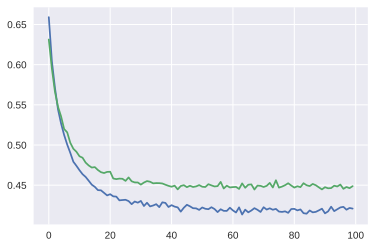

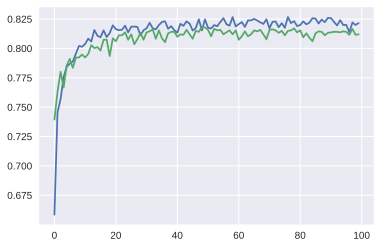

In [ ]:
class TextClassifierParameters:
    """Container class to store the hyperparameters that control the training process."""

    # Computation device: 'cuda' or 'cpu'
    device = 'cuda'

    # Maximal vocabulary size: by increasing, the system will probably be slower but more accurate.
    max_voc_size = 1000

    # Number of training epochs.
    n_epochs = 100

    # Size of batches: how many documents to process in parallel.
    batch_size = 64

    # Learning rate in the Adam optimizer.
    eta = 2e-2

    # Weight decay (L2 regularization) in the Adam optimizer.
    decay = 1e-6
    
    # Dropout probability.
    dropout = 0.2
   
def main_bow():
    global clf
    
    # Set a random seed for reproducibility.
    torch.manual_seed(0)
    
    # Read the data.
    X, Y = read_data('data/all_sentiment_shuffled.txt', use_sentiment=True)
    
    # Initialize the text classifier
    params = TextClassifierParameters()    
    clf = TextClassifier(params)
    
    # Preprocess the data.
    clf.preprocess(X, Y)

    # Create a classification model: a bag-of-words representation with a linear classifier on top,
    # and dropout to reduce overfitting.
    clf.set_model(nn.Sequential(
            BagOfWordsEncoder(clf.voc_size),
            nn.Dropout(params.dropout),
            nn.Linear(in_features=clf.voc_size, out_features=clf.n_classes)            
    ))
    
    # Train the classifier.
    clf.train()

    # Plot losses and accuracies for the training and validation sets.
    plt.figure()
    plt.plot(clf.history['train_loss'])
    plt.plot(clf.history['val_loss'])

    plt.figure()
    plt.plot(clf.history['train_acc'])
    plt.plot(clf.history['val_acc'])
    
main_bow()

In [ ]:
# lets exemplify how the classifier works by applying it to a couple of documents
clf.predict(['i dislike this book !', ' i hate this awful toaster !'])

['neg', 'neg']

In [ ]:
# Now we will implement ir using a CBoW approach. As opposed to BoW, CBoW entails learned representation.

class CBoWEncoder(nn.Module):
  
  def __init__(self, voc_size, emb_dim):
    super().__init__()
    self.embedding = nn.Embedding(voc_size, emb_dim)

  def forward(self, X):
    # X is a document tensor with shape (n_docs, n_words)

    embedded = self.embedding(X)

    # We now have a tensor with embeddings of the words in the documents.
    # This tensor has the shape (n_docs, n_words, emd_dim)
    # We compute the mean over the second dimension (the words in each document).

    return embedded.mean(dim=1)

Epoch 5: train loss:0.6728, train acc: 0.6088,val loss: 0.6690, val acc: 0.6118, time: 0.9494
Epoch 10: train loss:0.5316, train acc: 0.7997,val loss: 0.5571, val acc: 0.7625, time: 0.9542
Epoch 15: train loss:0.4181, train acc: 0.8597,val loss: 0.4838, val acc: 0.8015, time: 0.9324
Epoch 20: train loss:0.3471, train acc: 0.8888,val loss: 0.4461, val acc: 0.8254, time: 0.8862
Epoch 25: train loss:0.2873, train acc: 0.9109,val loss: 0.4381, val acc: 0.8347, time: 0.8865
Epoch 30: train loss:0.2438, train acc: 0.9337,val loss: 0.4090, val acc: 0.8271, time: 0.8934
Epoch 35: train loss:0.2120, train acc: 0.9412,val loss: 0.4146, val acc: 0.8317, time: 0.9118
Epoch 40: train loss:0.1832, train acc: 0.9541,val loss: 0.4198, val acc: 0.8372, time: 0.8856
Epoch 45: train loss:0.1601, train acc: 0.9591,val loss: 0.4344, val acc: 0.8175, time: 0.9011
Epoch 50: train loss:0.1404, train acc: 0.9684,val loss: 0.4656, val acc: 0.8334, time: 0.8954


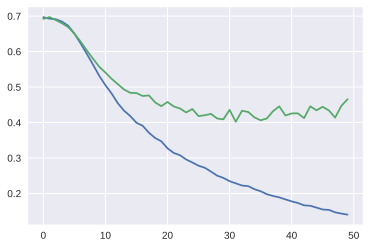

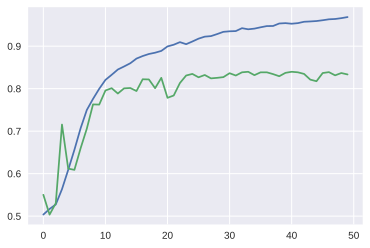

In [ ]:
# We rewrirte the main function that trains the classifier in an almost identiacal fashion
# We make small tweaks

class TextClassifierParameters:
  device = 'cuda'

  max_voc_size = None

  n_epochs = 50
  batch_size = 64

  eta = 3e-3
  decay = 1e-6
  dropout = 0.2

  emb_dim = 16

def main_cbow():
  global clf

  torch.manual_seed(0)

  X, Y = read_data('data/all_sentiment_shuffled.txt', use_sentiment=True)

  params = TextClassifierParameters()

  clf = TextClassifier(params)

  clf.preprocess(X, Y)

  # Create a classification model: a continous bag-of-words representation with a linear classifier
  # on top, and dropout to reduce overfitting.

  clf.set_model(nn.Sequential(
          CBoWEncoder(clf.voc_size, params.emb_dim),
          nn.Dropout(params.dropout),
          nn.Linear(in_features=params.emb_dim, out_features=clf.n_classes)
  ))

  clf.train()

  plt.figure()
  plt.plot(clf.history['train_loss'])
  plt.plot(clf.history['val_loss'])


  plt.figure()
  plt.plot(clf.history['train_acc'])
  plt.plot(clf.history['val_acc'])

main_cbow()

In [ ]:
# Again, just as a sanity check, let's apply the model to some words.

clf.predict(['I found this material very underwhelming','I dislike this book very much'])

['neg', 'neg']